In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot
import os
from copy import deepcopy


from time import time

from math import ceil
from scipy.stats import spearmanr, gamma, poisson
import scipy.sparse as sp
from scipy.io import mmread

from anndata import AnnData, read_h5ad
import anndata as ad
import scanpy as sc
from scanpy import read
import pandas as pd

from torch.utils.data import DataLoader, TensorDataset
from torch import tensor
from torch.cuda import is_available
import importlib
import sys
import umap


/home/nandivada.s/projects/vanaja_lab/satya/envs/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from Preprocess import prepare_train_test_anndata

data = prepare_train_test_anndata()

All sample IDs in gene data: ['AML0612' 'AML3762' 'AML3133' 'AML2910' 'AML3050' 'AML2451' 'AML056'
 'AML073' 'AML055' 'AML048' 'AML052' 'AML2123' 'AML1371' 'AML4340'
 'AML4897' 'AML051' 'AML0693' 'AML3948' 'AML3730' 'AML0160' 'AML0310'
 'AML0361' 'AML038' 'AML008' 'AML043' 'AML028' 'AML006' 'AML025' 'AML003'
 'AML012' 'AML005' 'AML0048' 'AML022' 'AML0024' 'AML009' 'AML026' 'AML001'
 'AML0114' 'Control4' 'Control2' 'Control1' 'Control3' 'Control5'
 'Control0004' 'Control0058' 'Control0082' 'Control4003' 'Control0005']
AML 80% train: ['AML0024', 'AML001', 'AML3050', 'AML4340', 'AML005', 'AML006', 'AML056', 'AML025', 'AML043', 'AML051', 'AML3948', 'AML055', 'AML0693', 'AML1371', 'AML0160', 'AML048', 'AML022', 'AML0612', 'AML028', 'AML2451', 'AML2123', 'AML3762', 'AML0114', 'AML0361', 'AML3133', 'AML012', 'AML026', 'AML2910', 'AML009', 'AML008', 'AML0048']
AML 20% test: ['AML052', 'AML038', 'AML3730', 'AML0310', 'AML073', 'AML4897', 'AML003']
Control 80% train: ['Control4003', 'Control1', 

In [3]:
trainGene = data[0]
trainGene

AnnData object with n_obs × n_vars = 158179 × 36601
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell', 'UMAP_1', 'UMAP_2', 'samples', 'Broad_cell_identity', 'Cell_type_identity', 'clusters_res.2', 'CNV_pos', 'malignant', 'aml', 'ap_aml_age', 'age_group', 'sex', 'inflammation_group', 'occupancy_score', 'sample', 'unintegrated_clusters', 'seurat_clusters', 'RNA_snn_res.1', 'source'
    obsm: 'X_integrated.cca', 'X_pca', 'X_umap', 'X_umap.unintegrated'
    layers: 'counts'

/home/nandivada.s/projects/vanaja_lab/satya/envs/myenv/lib/python3.12/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


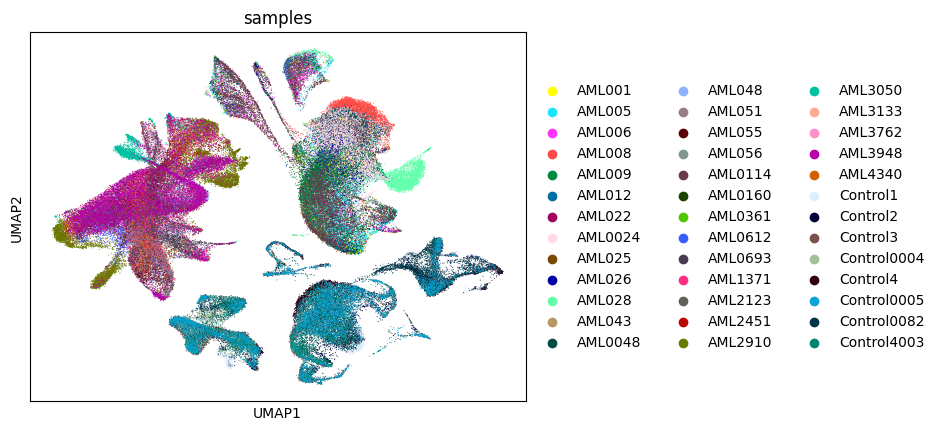

/tmp/ipykernel_178621/1544031549.py:24: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(trainGene, resolution=1.0)


In [4]:
import scanpy as sc
import scanpy.external as sce  # Harmony & BBKNN live here

# ---- basic counts-level prep ----
sc.pp.normalize_total(trainGene, target_sum=1e4)   # library-size normaliz
sc.pp.log1p(trainGene)
sc.pp.highly_variable_genes(trainGene, n_top_genes=2000, batch_key="samples")
trainGene = trainGene[:, trainGene.var.highly_variable].copy()

sc.pp.scale(trainGene, max_value=10)
sc.tl.pca(trainGene, n_comps=50, svd_solver="arpack")

sc.pp.neighbors(
    trainGene,
    use_rep="X_integrated.cca",   # tells Scanpy to pull from .obsm["X_integrated.cca"]
    n_neighbors=15,               # tweak if needed
    n_pcs=trainGene.obsm["X_integrated.cca"].shape[1],  # use all available dims
)

# Compute the 2‑D UMAP
sc.tl.umap(trainGene)
sc.pl.umap(trainGene, color="samples", size=2)

sc.tl.leiden(trainGene, resolution=1.0)




In [5]:
trainGene

AnnData object with n_obs × n_vars = 158179 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell', 'UMAP_1', 'UMAP_2', 'samples', 'Broad_cell_identity', 'Cell_type_identity', 'clusters_res.2', 'CNV_pos', 'malignant', 'aml', 'ap_aml_age', 'age_group', 'sex', 'inflammation_group', 'occupancy_score', 'sample', 'unintegrated_clusters', 'seurat_clusters', 'RNA_snn_res.1', 'source', 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'samples_colors', 'leiden'
    obsm: 'X_integrated.cca', 'X_pca', 'X_umap', 'X_umap.unintegrated'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

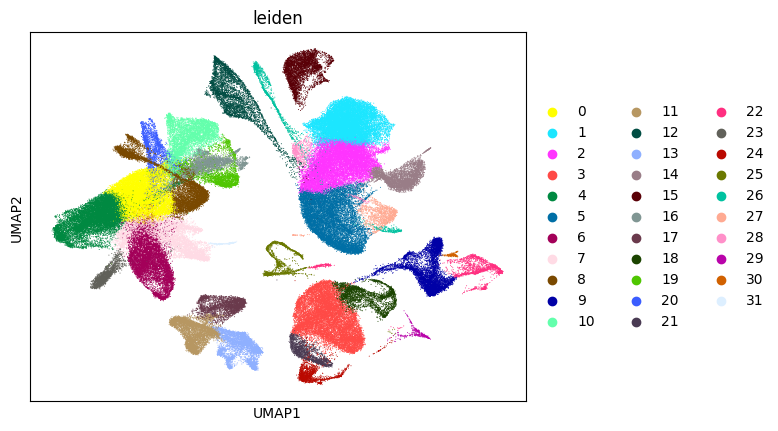

In [5]:
sc.pl.umap(trainGene, color="leiden" ,size=2)

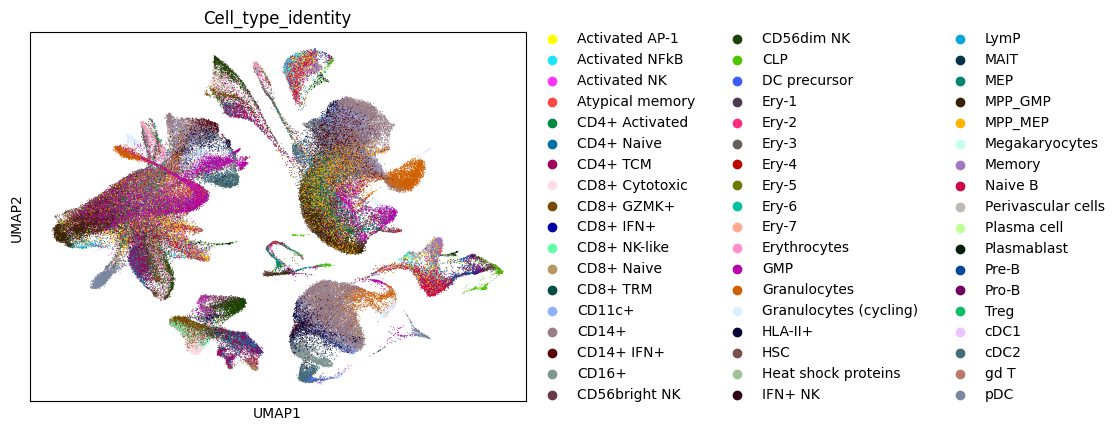

In [6]:
sc.pl.umap(trainGene, color="Cell_type_identity" ,size=2)

In [7]:
# 2) compute the three requested quantities
num_graphs   = 1                                 # single k‑NN graph
num_features = trainGene.X.shape[1]                        # feature dimension
num_classes  = trainGene.obs["leiden"].nunique() # distinct Leiden clusters

print(f"Number of graphs:   {num_graphs}")
print(f"Number of features: {num_features}")
print(f"Number of classes:  {num_classes}")

Number of graphs:   1
Number of features: 2000
Number of classes:  32


In [8]:


# assumes you have already run sc.pp.neighbors / BBKNN on `trainGene`
A = trainGene.obsp["connectivities"]            # sparse adjacency
num_nodes = trainGene.n_obs

# --- edge count ----------------------------------------------------------
# If the graph is undirected (A == A.T), each edge is stored twice
is_undirected = (A != A.T).nnz == 0
diag_nnz      = A.diagonal().nonzero()[0].size  # possible self‑loops
if is_undirected:
    num_edges = (A.nnz - diag_nnz) // 2 + diag_nnz
else:
    num_edges = A.nn

avg_deg = num_edges / num_nodes

# --- training mask -------------------------------------------------------
# If you stored a boolean mask in .obs, use it – otherwise treat *all* nodes as training
train_mask = (
    trainGene.obs["train_mask"].to_numpy()
    if "train_mask" in trainGene.obs
    else np.ones(num_nodes, dtype=bool)
)
num_train_nodes  = train_mask.sum()
train_label_rate = num_train_nodes / num_nodes

# --- graph diagnostics ---------------------------------------------------
has_isolated = (A.sum(axis=1).A1 == 0).any()
has_selfloops = diag_nnz > 0

print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Average node degree: {avg_deg:.2f}")
print(f"Number of training nodes: {num_train_nodes}")
print(f"Training node label rate: {train_label_rate:.2f}")
print(f"Has isolated nodes: {has_isolated}")
print(f"Has self-loops: {has_selfloops}")
print(f"Is undirected: {is_undirected}")


Number of nodes: 158179
Number of edges: 2017088
Average node degree: 12.75
Number of training nodes: 158179
Training node label rate: 1.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True


/tmp/ipykernel_178621/1493967758.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(unique_labels))


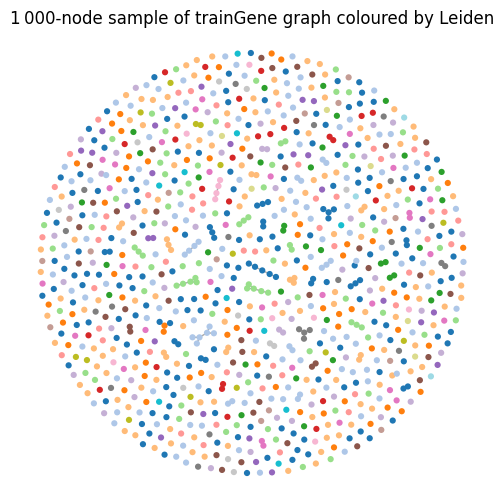

In [9]:
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
from scipy import sparse

# -------------------------------------------------------------------------
# 1) pick node features and labels
# -------------------------------------------------------------------------
X = (
    trainGene.obsm["X_integrated.cca"]
    if "X_integrated.cca" in trainGene.obsm
    else trainGene.obsm["X_pca"]
)
y = trainGene.obs["leiden"].astype(int).to_numpy()

# -------------------------------------------------------------------------
# 2) build edge index from Scanpy connectivities
# -------------------------------------------------------------------------
A = trainGene.obsp["connectivities"].tocsr()              # guaranteed CSR
# keep only upper‑triangle to avoid duplicate edges
A_triu = sparse.triu(A, k=1)
row, col = A_triu.nonzero()
edge_index = torch.tensor(np.vstack([row, col]), dtype=torch.long)

# -------------------------------------------------------------------------
# 3) assemble PyG Data
# -------------------------------------------------------------------------
data = Data(
    x=torch.tensor(X, dtype=torch.float32),
    edge_index=edge_index,
    y=torch.tensor(y, dtype=torch.long),
)

# -------------------------------------------------------------------------
# 4) convert to NetworkX
# -------------------------------------------------------------------------
G_full = to_networkx(data, to_undirected=True)

# -------------------------------------------------------------------------
# 5) visualise a 1 000‑node induced sub‑graph for clarity
# -------------------------------------------------------------------------
np.random.seed(0)
subset = np.random.choice(data.num_nodes, size=1_000, replace=False)
G_sub = G_full.subgraph(subset)

# map Leiden labels to colours
labels_sub = {i: int(data.y[i]) for i in subset}
unique_labels = sorted(set(labels_sub.values()))
cmap = plt.cm.get_cmap("tab20", len(unique_labels))
node_colors = [cmap(labels_sub[n]) for n in G_sub.nodes]

plt.figure(figsize=(6, 6))
nx.draw_networkx(
    G_sub,
    pos=nx.spring_layout(G_sub, seed=1),
    node_size=20,
    node_color=node_colors,
    with_labels=False,
    edge_color="#AAAAAA",
    linewidths=0.0,
)
plt.axis("off")
plt.title("1 000‑node sample of trainGene graph coloured by Leiden")
plt.show()


In [16]:
# -------------------------------------------------------------------------
# Use the `data` object you built from trainGene (features = embedding,
# labels = Leiden). We add train/val/test masks and adapt the MLP training.
# -------------------------------------------------------------------------
import numpy as np
import torch
from torch import nn
from sklearn.model_selection import StratifiedShuffleSplit
from torch_geometric.nn import GATConv
import torch.nn.functional as F

# ----- create train/val/test masks (stratified by Leiden labels) ----------
N = data.num_nodes
y_np = data.y.cpu().numpy()

# first split train vs temp (train_frac = 0.8)
sss1 = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=42)
train_idx, temp_idx = next(sss1.split(np.zeros(N), y_np))

# split temp into val/test 50/50 → 10% each of total
y_temp = y_np[temp_idx]
sss2 = StratifiedShuffleSplit(n_splits=1, train_size=0.5, random_state=43)
val_rel, test_rel = next(sss2.split(np.zeros(len(temp_idx)), y_temp))
val_idx  = temp_idx[val_rel]
test_idx = temp_idx[test_rel]

train_mask = torch.zeros(N, dtype=torch.bool)
val_mask   = torch.zeros(N, dtype=torch.bool)
test_mask  = torch.zeros(N, dtype=torch.bool)
train_mask[train_idx] = True
val_mask[val_idx]     = True
test_mask[test_idx]   = True

data.train_mask = train_mask
data.val_mask   = val_mask
data.test_mask  = test_mask

print(
    f"Split sizes → train: {train_mask.sum().item()} | "
    f"val: {val_mask.sum().item()} | test: {test_mask.sum().item()}"
)


in_dim  = data.x.size(1)
n_class = int(data.y.max().item() + 1)



class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(in_dim, hidden_channels)  # TODO
        self.conv2 = GATConv(hidden_channels, n_class)  # TODO

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GAT(hidden_channels=8, heads=8).to(device)
data = data.to(device)  
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return acc

for epoch in range(1, 501):
    loss = train()
    
    if epoch % 10 == 0 or epoch == 1:
        val_acc = test(data.val_mask)
        test_acc = test(data.test_mask)
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')



Split sizes → train: 126543 | val: 15818 | test: 15818
GAT(
  (conv1): GATConv(50, 8, heads=1)
  (conv2): GATConv(8, 32, heads=1)
)
Epoch: 001, Loss: 4.6928, Val: 0.0168, Test: 0.0176
Epoch: 010, Loss: 3.5432, Val: 0.0792, Test: 0.0760
Epoch: 020, Loss: 3.1948, Val: 0.2046, Test: 0.2017
Epoch: 030, Loss: 2.9010, Val: 0.3423, Test: 0.3449
Epoch: 040, Loss: 2.6276, Val: 0.4294, Test: 0.4322
Epoch: 050, Loss: 2.3602, Val: 0.4947, Test: 0.4964
Epoch: 060, Loss: 2.1287, Val: 0.5623, Test: 0.5635
Epoch: 070, Loss: 1.9370, Val: 0.6067, Test: 0.6070
Epoch: 080, Loss: 1.7634, Val: 0.6780, Test: 0.6775
Epoch: 090, Loss: 1.6270, Val: 0.7259, Test: 0.7267
Epoch: 100, Loss: 1.5263, Val: 0.7532, Test: 0.7586
Epoch: 110, Loss: 1.4638, Val: 0.7748, Test: 0.7780
Epoch: 120, Loss: 1.3917, Val: 0.7806, Test: 0.7838
Epoch: 130, Loss: 1.3534, Val: 0.7933, Test: 0.7965
Epoch: 140, Loss: 1.2999, Val: 0.7986, Test: 0.7992
Epoch: 150, Loss: 1.2648, Val: 0.8053, Test: 0.8071
Epoch: 160, Loss: 1.2355, Val: 0.810

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [ ]:
model = GCN(hidden_channels=16)
model.eval()
out = model(data.x, data.edge_index)   # logits
visualize(out, color=data.y)

In [33]:
data

Data(x=[158179, 50], edge_index=[2, 2017088], y=[158179], train_mask=[158179], val_mask=[158179], test_mask=[158179])

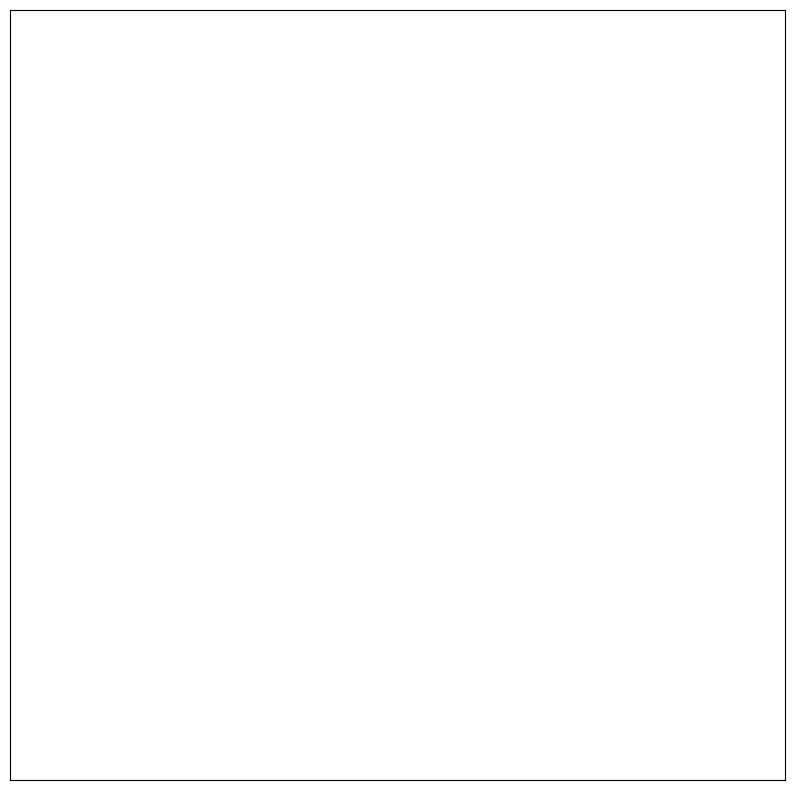

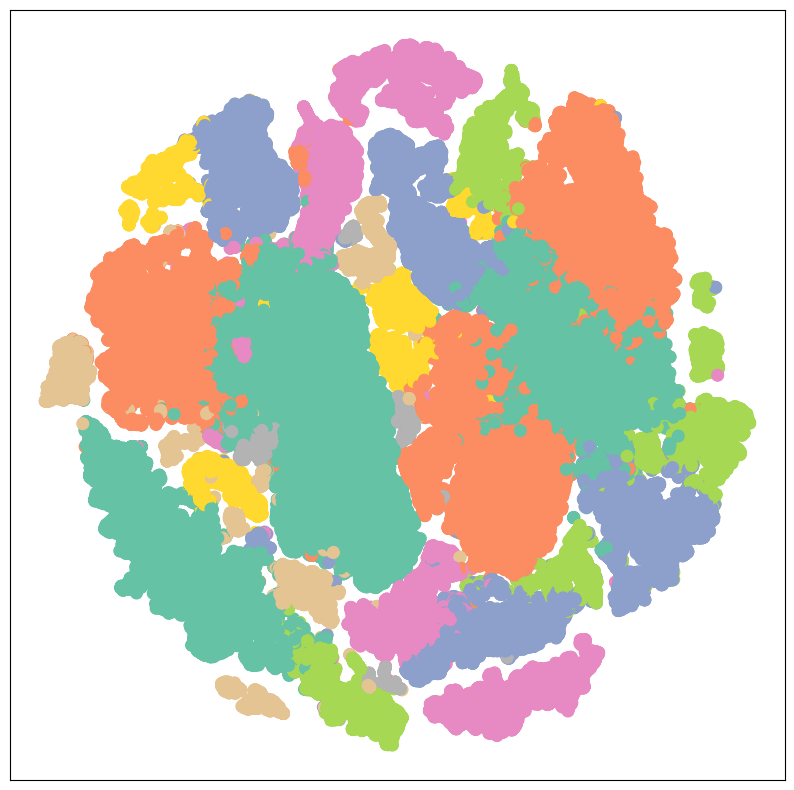

In [27]:
model.eval()
out = model(data.x, data.edge_index)
data = data.to('cpu')   
visualize(out, color=data.y)